**Obiettivo:** Data una lista di documenti testuali, ed una query in formato testuale, reperire i documenti più pertinenti alla query. \\

**Strumenti:** Transformers che creano un embedding sia per i documenti che per la query, in modo da poter sfruttare una misura di similarità documento-query per reperire i documenti più simili e quindi pertinenti.


## **BERT** *(Sconsigliato, ad oggi esistono modelli più performanti su questo task)*

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

model_name = "sentence-transformers/bert-base-nli-mean-tokens"
# https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens

In [13]:
def create_embedding(x, tokenizer, model):
  """Crea l' embedding della lista di documenti passati, sottoforma di una lista di stringhe (x)"""

  tokens = {'input_ids':[], 'attention_mask':[]}
  for sentence in x:
    new_tokens = tokenizer.encode_plus(sentence,
                          max_length=128,
                          truncation=True,
                          padding = 'max_length',
                          return_tensors = 'pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)

  embeddings = outputs.last_hidden_state

  attention = tokens['attention_mask']
  mask = attention.unsqueeze(-1).expand(embeddings.shape).float()

  mask_embeddings = embeddings*mask

  summed = torch.sum(mask_embeddings, 1)
  counts = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed/counts
  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

In [14]:
def get_pertinent_documents(query_embedding, documents_embeddings, documents):
  """Dato l'embedding di una query, e di una lista di documenti, stampa l'ordinamento dei documenti in ordine di pertinenza"""

  sim = cosine_similarity(
    query_embedding,
    documents_embeddings
    )
  order = sorted(range(len(sim[0])), key=lambda k: sim[0][k])
  order.reverse()

  for i,j in enumerate(order):
    print(f"{i}: {documents[j]}")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [39]:
documents = ["La Pinacoteca di Brera, situata nel cuore di Milano, è una prestigiosa galleria d'arte che ospita una ricca collezione di opere italiane dal XIV al XX secolo. Celebrata per capolavori di artisti come Raphael, Caravaggio e Mantegna",
"Roma è il cuore pulsante della storia e della cultura italiana. Con oltre duemila anni di storia, la città vanta imponenti monumenti come il Colosseo e il Pantheon, testimonianze della grandezza dell'antica Roma. Il Vaticano, con la Basilica di San Pietro e la Cappella Sistina, aggiunge un tocco spirituale a questa metropoli cosmopolita, che continua a incantare con la sua architettura maestosa e il suo stile di vita vibrante",
"Il rugby, sport di squadra nato nell'Inghilterra del XIX secolo, si distingue per la sua combinazione di forza, tattica e fair play. Caratterizzato dai placcaggi e dalla solidarietà di squadra, il rugby promuove valori di lealtà e rispetto, creando un'atmosfera unica di cameratismo sul campo di gioco",
"Milano, capitale economica e della moda italiana, incanta con la sua vibrante energia urbana. Icone architettoniche come il Duomo e la moderna skyline si fondono con l'arte contemporanea e la vivace scena culinaria. Centro pulsante di innovazione e cultura, Milano è una città dinamica che unisce tradizione e modernità con eleganza e stile",
"I fantasmi, creature leggendarie che popolano l'immaginario collettivo, sono spesso associati al mistero e all'oltremondano. I fantasmi evocano sensazioni di timore e curiosità, alimentando paure in molte persone",
"Il tofu, derivato dalla soia, è un versatile alimento ricco di proteine e povero di grassi. Apprezzato per la sua consistenza delicata, il tofu si presta a molteplici preparazioni culinarie, assumendo sapori diversi nelle varie cucine del mondo. La sua versatilità lo rende una scelta popolare per chi segue diete vegetariane e vegane",
"Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana",
"Vinavil è un adesivo vinilico multiuso noto per la sua versatilità e aderenza affidabile. Utilizzato comunemente in ambito scolastico e fai-da-te, Vinavil è apprezzato per la sua capacità di incollare diversi materiali, dalla carta al legno, offrendo una soluzione pratica e resistente per molteplici progetti",
"Il cellulare, ormai indispensabile nella vita moderna, è uno strumento versatile che va oltre la semplice comunicazione. Con funzionalità avanzate, come fotocamere di alta qualità, accesso a internet e applicazioni specializzate, il cellulare si è trasformato in un compagno quotidiano, rivoluzionando la nostra connessione con il mondo e le relazioni sociali",
"L'Intelligenza Artificiale (AI) rappresenta una frontiera rivoluzionaria nell'informatica, consentendo alle macchine di apprendere, ragionare e risolvere problemi complessi in modo simile all'intelligenza umana. Dalle applicazioni pratiche come assistenti virtuali e veicoli autonomi a scopi più avanzati come la diagnosi medica, l'AI continua a plasmare il futuro con innovazioni che sfidano i limiti delle capacità umane"]

query = "Sto cercando un posto artistico da visitare in italia, cosa potrei scegliere"

In [15]:
documents_embeddings = create_embedding(documents, tokenizer, model)
query_embedding = create_embedding([query], tokenizer, model)

In [16]:
get_pertinent_documents(query_embedding, documents_embeddings, documents)

0: La Pinacoteca di Brera, situata nel cuore di Milano, è una prestigiosa galleria d'arte che ospita una ricca collezione di opere italiane dal XIV al XX secolo. Celebrata per capolavori di artisti come Raphael, Caravaggio e Mantegna
1: Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana
2: Roma è il cuore pulsante della storia e della cultura italiana. Con oltre duemila anni di storia, la città vanta imponenti monumenti come il Colosseo e il Pantheon, testimonianze della grandezza dell'antica Roma. Il Vaticano, con la Basilica di San Pietro e la Cappella Sistina, aggiunge un tocco spirituale a questa metropoli cosmopolita, che continua a incantare con la sua architettura maestosa e il suo stile di vita vibrante
3: I fantasmi

## **NUOVI MODELLI**

I modelli ad oggi consigliati sono i seguenti:

* all-mpnet-base-v2
* multi-qa-mpnet-base-dot-v1
* all-distilroberta-v1
* all-MiniLM-L12-v2
* multi-qa-distilbert-cos-v1
* all-MiniLM-L6-v2

Quasi tutti sono versioni fine-tunate di modelli piu "famosi", la documentazione è consultabile al seguente link: \\
https://www.sbert.net/docs/pretrained_models.html


In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [ ]:
#Genero dei documenti di esempio, appartenenti a categorie diverse
documents = [
    "La Pinacoteca di Brera, situata nel cuore di Milano, è una prestigiosa galleria d'arte che ospita una ricca collezione di opere italiane dal XIV al XX secolo. Celebrata per capolavori di artisti come Raphael, Caravaggio e Mantegna",
    "Roma è il cuore pulsante della storia e della cultura italiana. Con oltre duemila anni di storia, la città vanta imponenti monumenti come il Colosseo e il Pantheon, testimonianze della grandezza dell'antica Roma. Il Vaticano, con la Basilica di San Pietro e la Cappella Sistina, aggiunge un tocco spirituale a questa metropoli cosmopolita, che continua a incantare con la sua architettura maestosa e il suo stile di vita vibrante",
    "Il rugby, sport di squadra nato nell'Inghilterra del XIX secolo, si distingue per la sua combinazione di forza, tattica e fair play. Caratterizzato dai placcaggi e dalla solidarietà di squadra, il rugby promuove valori di lealtà e rispetto, creando un'atmosfera unica di cameratismo sul campo di gioco",
    "Milano, capitale economica e della moda italiana, incanta con la sua vibrante energia urbana. Icone architettoniche come il Duomo e la moderna skyline si fondono con l'arte contemporanea e la vivace scena culinaria. Centro pulsante di innovazione e cultura, Milano è una città dinamica che unisce tradizione e modernità con eleganza e stile",
    "I fantasmi, creature leggendarie che popolano l'immaginario collettivo, sono spesso associati al mistero e all'oltremondano. I fantasmi evocano sensazioni di timore e curiosità, alimentando paure in molte persone",
    "Il tofu, derivato dalla soia, è un versatile alimento ricco di proteine e povero di grassi. Apprezzato per la sua consistenza delicata, il tofu si presta a molteplici preparazioni culinarie, assumendo sapori diversi nelle varie cucine del mondo. La sua versatilità lo rende una scelta popolare per chi segue diete vegetariane e vegane",
    "Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana",
    "Vinavil è un adesivo vinilico multiuso noto per la sua versatilità e aderenza affidabile. Utilizzato comunemente in ambito scolastico e fai-da-te, Vinavil è apprezzato per la sua capacità di incollare diversi materiali, dalla carta al legno, offrendo una soluzione pratica e resistente per molteplici progetti",
    "Il cellulare, ormai indispensabile nella vita moderna, è uno strumento versatile che va oltre la semplice comunicazione. Con funzionalità avanzate, come fotocamere di alta qualità, accesso a internet e applicazioni specializzate, il cellulare si è trasformato in un compagno quotidiano, rivoluzionando la nostra connessione con il mondo e le relazioni sociali",
    "L'Intelligenza Artificiale (AI) rappresenta una frontiera rivoluzionaria nell'informatica, consentendo alle macchine di apprendere, ragionare e risolvere problemi complessi in modo simile all'intelligenza umana. Dalle applicazioni pratiche come assistenti virtuali e veicoli autonomi a scopi più avanzati come la diagnosi medica, l'AI continua a plasmare il futuro con innovazioni che sfidano i limiti delle capacità umane"
]

In [56]:
def get_best_documents(model_name, query, documents):
  """Calcola l'embedding dei documenti e della query, e utilizza una misura di similarità (dot product) per identificare i documenti più pertinenti"""

  model = SentenceTransformer(model_name)
  query_embedding = model.encode(query)
  documents_embedding = model.encode(documents)
  sim = util.dot_score(query_embedding, documents_embedding)
  order = sorted(range(len(sim[0])), key=lambda k: sim[0][k])
  order.reverse()
  for i,j in enumerate(order):
    print(f"{i}: ({sim[0][j]}) - {documents[j]}")

In [ ]:
query = "Sto cercando un posto artistico da visitare in italia, cosa potrei scegliere"

In [50]:
# Per ogni modello analizziamo la classifica di documenti restituita, con di fianco lo score di similarità calcolato
for m in ['all-mpnet-base-v2','multi-qa-mpnet-base-dot-v1','all-distilroberta-v1','all-MiniLM-L12-v2','multi-qa-distilbert-cos-v1','all-MiniLM-L6-v2']:
  print(f"###  {m}  #############################################################")
  get_best_documents(m, query, documents)
  print("\n\n")

###  all-mpnet-base-v2  #############################################################
0: (0.6867842674255371) - La Pinacoteca di Brera, situata nel cuore di Milano, è una prestigiosa galleria d'arte che ospita una ricca collezione di opere italiane dal XIV al XX secolo. Celebrata per capolavori di artisti come Raphael, Caravaggio e Mantegna
1: (0.6862706542015076) - Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana
2: (0.6269183158874512) - Milano, capitale economica e della moda italiana, incanta con la sua vibrante energia urbana. Icone architettoniche come il Duomo e la moderna skyline si fondono con l'arte contemporanea e la vivace scena culinaria. Centro pulsante di innovazione e cultura, Milano è una città dinamica ch

In [60]:
query = "Quale è un cibo che posso inserire nella mia dieta"

In [61]:
# Per ogni modello analizziamo la classifica di documenti restituita, con di fianco lo score di similarità calcolato
for m in ['all-mpnet-base-v2','multi-qa-mpnet-base-dot-v1','all-distilroberta-v1','all-MiniLM-L12-v2','multi-qa-distilbert-cos-v1','all-MiniLM-L6-v2']:
  print(f"###  {m}  #############################################################")
  get_best_documents(m, query, documents)
  print("\n\n")

###  all-mpnet-base-v2  #############################################################
0: (0.48335760831832886) - Il tofu, derivato dalla soia, è un versatile alimento ricco di proteine e povero di grassi. Apprezzato per la sua consistenza delicata, il tofu si presta a molteplici preparazioni culinarie, assumendo sapori diversi nelle varie cucine del mondo. La sua versatilità lo rende una scelta popolare per chi segue diete vegetariane e vegane
1: (0.45660293102264404) - Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana
2: (0.42099618911743164) - Il cellulare, ormai indispensabile nella vita moderna, è uno strumento versatile che va oltre la semplice comunicazione. Con funzionalità avanzate, come fotocamere di alta qualità, 

In [64]:
query = "Sto cercando una atività fisica di squadra da fare nel tempo libero"

In [65]:
# Per ogni modello analizziamo la classifica di documenti restituita, con di fianco lo score di similarità calcolato
for m in ['all-mpnet-base-v2','multi-qa-mpnet-base-dot-v1','all-distilroberta-v1','all-MiniLM-L12-v2','multi-qa-distilbert-cos-v1','all-MiniLM-L6-v2']:
  print(f"###  {m}  #############################################################")
  get_best_documents(m, query, documents)
  print("\n\n")

###  all-mpnet-base-v2  #############################################################
0: (0.5891743302345276) - Il rugby, sport di squadra nato nell'Inghilterra del XIX secolo, si distingue per la sua combinazione di forza, tattica e fair play. Caratterizzato dai placcaggi e dalla solidarietà di squadra, il rugby promuove valori di lealtà e rispetto, creando un'atmosfera unica di cameratismo sul campo di gioco
1: (0.49108195304870605) - Gli Uffizi, situati nel cuore di Firenze, costituiscono uno dei musei d'arte più celebri al mondo. La loro straordinaria collezione comprende capolavori di artisti come Botticelli, Michelangelo e Leonardo da Vinci, offrendo ai visitatori un viaggio affascinante attraverso la storia dell'arte rinascimentale italiana
2: (0.4676651060581207) - Milano, capitale economica e della moda italiana, incanta con la sua vibrante energia urbana. Icone architettoniche come il Duomo e la moderna skyline si fondono con l'arte contemporanea e la vivace scena culinaria. 

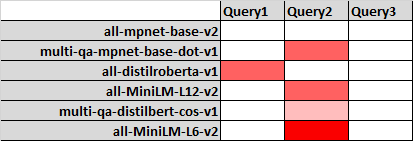

Il grafico sopra rappresenta una stima indicativa di come i modelli siano stati coerenti nei confronti delle 3 query provate. Tutti i modelli sembrano performare abbastanza bene, anche se quello che ha funzionato meglio con tutte le query è **all-mpnet-base-v2**